<a href="https://colab.research.google.com/github/Aashwin2202/IOP/blob/main/IOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dataset from Kaggle 


In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aash2202","key":"f509d43683224dc3b7bf573cd631737f"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d simranvolunesia/pest-dataset

 86% 60.0M/69.5M [00:00<00:00, 91.7MB/s]
100% 69.5M/69.5M [00:00<00:00, 87.2MB/s]


In [ ]:
!unzip pest-dataset.zip

## Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

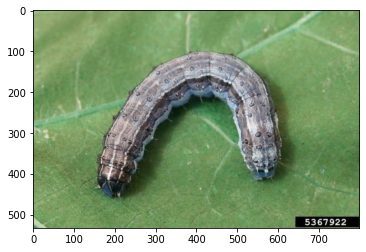

In [9]:
img=cv2.imread('/content/pest/train/armyworm/jpg_0 - Copy (2).jpg')
plt.imshow(img)
plt.show()

## Training and validating Generators

In [10]:
train_dir='/content/pest/train'
test_dir='/content/pest/test'

In [11]:
training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)

Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


## Transfer learning through Mobilenet

In [12]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17225924/17225924 [==============================] - 0s 0us/step


In [13]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Early Stopping

In [24]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [25]:
mobilenet.trainable=False

## Model

In [26]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                      

## Training

In [28]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [29]:
history=model.fit(training,validation_data=validing,epochs=40,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/40

Epoch 1: val_loss improved from inf to 9.71160, saving model to model.hdf5
10/10 - 6s - loss: 2.6576 - accuracy: 0.2250 - val_loss: 9.7116 - val_accuracy: 0.0625 - lr: 5.0000e-04 - 6s/epoch - 567ms/step
Epoch 2/40

Epoch 2: val_loss improved from 9.71160 to 4.80374, saving model to model.hdf5
10/10 - 3s - loss: 2.1105 - accuracy: 0.4500 - val_loss: 4.8037 - val_accuracy: 0.2500 - lr: 5.0000e-04 - 3s/epoch - 279ms/step
Epoch 3/40

Epoch 3: val_loss did not improve from 4.80374
10/10 - 3s - loss: 1.4450 - accuracy: 0.5813 - val_loss: 10.1677 - val_accuracy: 0.1875 - lr: 5.0000e-04 - 3s/epoch - 257ms/step
Epoch 4/40

Epoch 4: val_loss did not improve from 4.80374
10/10 - 3s - loss: 1.1832 - accuracy: 0.6438 - val_loss: 8.1667 - val_accuracy: 0.1250 - lr: 5.0000e-04 - 3s/epoch - 297ms/step
Epoch 5/40

Epoch 5: val_loss did not improve from 4.80374
10/10 - 2s - loss: 1.0590 - accuracy: 0.6625 - val_loss: 9.0353 - val_accuracy: 0.1250 - lr: 5.0000e-04 - 2s/epoch - 245ms/step
Epoc

In [30]:
loss , acc = model.evaluate(testing)

29/29 [==============================] - 2s 56ms/step - loss: 0.5175 - accuracy: 0.8400


## Evaluating Loss

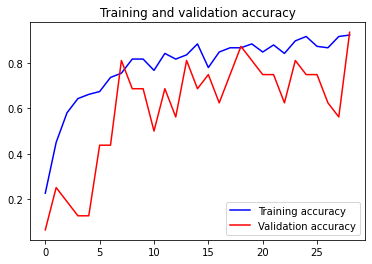

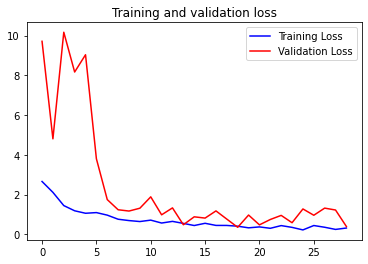

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()